# 1. Univariate LSTM Model

In [3]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from functools import reduce
from pandas import read_csv
from matplotlib import pyplot

# Import LSTM libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from keras.preprocessing.timeseries import TimeseriesGenerator
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import tensorflow as tf 
tf.keras.preprocessing.timeseries_dataset_from_array

<function keras.src.utils.timeseries_dataset_utils.timeseries_dataset_from_array(data, targets, sequence_length, sequence_stride=1, sampling_rate=1, batch_size=128, shuffle=False, seed=None, start_index=None, end_index=None)>

### Predicting CPI using lagged CPI data

In [5]:
cpi_df = pd.read_csv('cleaned_cpi.csv')

# Set date column as index
#cpi_df.set_index('Date', inplace = True)

# Remove change columns as we will be using the absolute index value for this
cpi_df.drop(columns = ['Value', 'ChangePercentYear'], axis = 1, inplace = True)
cpi_df.dropna(inplace = True)
len(cpi_df)

1310

In [6]:
cpi_train = cpi_df.iloc[:1190]
cpi_test = cpi_df.iloc[1190:]

# Pre-process data using a minmaxscaler to convert all data attributes to a range of 0-1
# Instantiate scaler object
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(cpi_train.set_index('Date'))
scaled_cpi_train = scaler.transform(cpi_train.set_index('Date'))
scaled_cpi_test = scaler.transform(cpi_test.set_index('Date'))

In [7]:
# define generator
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12  # We will use the last 12 months of CPI data to predict the next month
n_features = 1
generator = TimeseriesGenerator(scaled_cpi_train, scaled_cpi_train, length=n_input, batch_size=1)
validation_generator = TimeseriesGenerator(scaled_cpi_test, scaled_cpi_test, length=n_input, batch_size=1)

In [74]:
# define our LSTM model
from tensorflow.keras.models import Sequential
model = Sequential()
# LSTM with 100 nodes
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')   # loss function assigned to mean square error
model.summary()

# fit the model
# model.fit(generator, epochs = 50, validation_data=validation_generator)
history = model.fit(generator, epochs = 5, validation_data=validation_generator)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0200 - val_loss: 0.0045
Epoch 2/5
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0161 - val_loss: 0.0044
Epoch 3/5
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0197 - val_loss: 0.0051
Epoch 4/5
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0150 - val_loss: 0.0043
Epoch 5/5
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0137 - val_loss: 0.0044


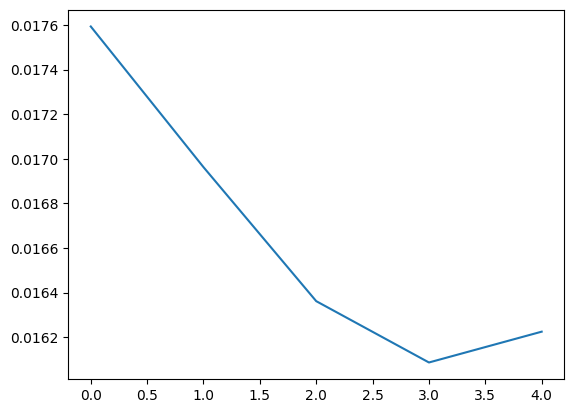

In [75]:
# plot the loss per epoch
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

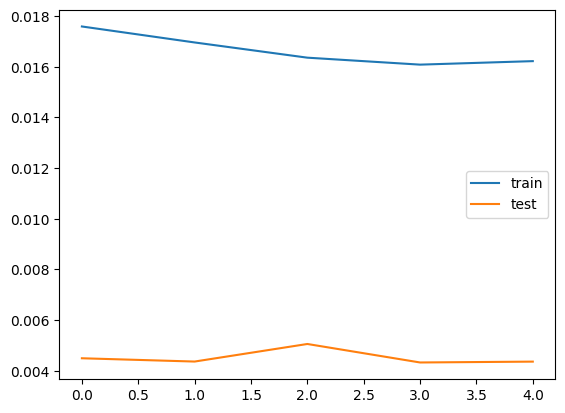

In [78]:
# plot history

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [69]:
import tensorflow as tf

class MapeMetric(tf.keras.metrics.Metric):
    def __init__(self, name='mape', **kwargs):
        super(MapeMetric, self).__init__(name=name, **kwargs)
        self.sum_absolute_percentage_error = tf.Variable(initial_value=0.0, dtype=tf.float32)
        self.count = tf.Variable(initial_value=0, dtype=tf.int32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        absolute_percentage_error = tf.abs((y_true - y_pred) / y_true)
        self.sum_absolute_percentage_error.assign_add(tf.reduce_sum(absolute_percentage_error))
        self.count.assign_add(tf.shape(y_true)[0])

    def result(self):
        return tf.math.divide_no_nan(self.sum_absolute_percentage_error, tf.cast(self.count, tf.float32)) * 100

    def reset_states(self):
        self.sum_absolute_percentage_error.assign(0.0)
        self.count.assign(0)

# print the metrics
print(f"MAE (Training): {mae.result().numpy()}")
print(f"MSE (Training): {mse.result().numpy()}")
print(f"RMSE (Training): {rmse.result().numpy()}")
print(f"MAPE (Training): {mape.result().numpy()}%")

# reset the metrics
mae = tf.keras.metrics.MeanAbsoluteError()
mse = tf.keras.metrics.MeanSquaredError()
rmse = tf.keras.metrics.RootMeanSquaredError()
mape = MapeMetric()  # Use the custom MapeMetric class

# repeat the process for the validation generator
for x, y in validation_generator:
    predictions = model.predict(x)
    y = tf.cast(y, dtype=tf.float32)
    mae.update_state(y, predictions)
    mse.update_state(y, predictions)
    rmse.update_state(y, predictions)
    mape.update_state(y, predictions)

# print the metrics
print(f"MAE (Validation): {mae.result().numpy()}")
print(f"MSE (Validation): {mse.result().numpy()}")
print(f"RMSE (Validation): {rmse.result().numpy()}")
print(f"MAPE (Validation): {mape.result().numpy()}%")

MAE (Training): 0.048035167157649994
MSE (Training): 0.0035603451542556286
RMSE (Training): 0.05966862663626671
MAPE (Training): 42.54735565185547%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━

In [62]:
# Use the trained model to generate and store our test predictions
test_predictions = []

first_eval_batch = scaled_cpi_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
n=0

for i in range(len(scaled_cpi_test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 

    # # print the prediction with the input
    # print(f"Input: {current_batch}")
    # print(f"Prediction: {current_pred}")
    # print("------------------------")
    
    
    # remove the first value and update the batch with the next value from the test set
    current_batch = np.append(current_batch[:,1:,:],scaled_cpi_test[n:n+1].reshape((1, 1, n_features)),axis=1)
    n += 1



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

In [63]:
import numpy as np

# calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(np.array(test_predictions) - np.array(scaled_cpi_test)))
print(f"MAE: {mae}")

# calculate Mean Squared Error (MSE)
mse = np.mean((np.array(test_predictions) - np.array(scaled_cpi_test)) ** 2)
print(f"MSE: {mse}")

# calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((np.array(test_predictions) - np.array(scaled_cpi_test)) / np.array(scaled_cpi_test))) * 100
print(f"MAPE: {mape}%")

MAE: 0.05004067694680791
MSE: 0.0037910455755745605
RMSE: 0.0615714672196023
MAPE: 41.29657824181084%


In [12]:
# Convert our predictions back to their pre scaled forms
true_predictions = scaler.inverse_transform(test_predictions)

# Apend the predictions back to the test data set
cpi_test['Predictions'] = true_predictions

C:\Users\Suryanshu Choudhary\AppData\Local\Temp\ipykernel_11416\3862874477.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_test['Predictions'] = true_predictions


In [13]:
import numpy as np

# Generate predictions for the training data
train_predictions = []
first_eval_batch = scaled_cpi_train[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(scaled_cpi_train) - n_input):
    current_pred = model.predict(current_batch)[0]
    train_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

# Inverse transform the predictions and the true values to get them back to the original scale
train_predictions = scaler.inverse_transform(train_predictions)
true_train_values = scaler.inverse_transform(scaled_cpi_train[n_input:])

# Calculate RMSE for the training data
train_rmse = sqrt(mean_squared_error(true_train_values, train_predictions))
print('Train RMSE:', train_rmse)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

Test RMSE: 0.0030218561644155973


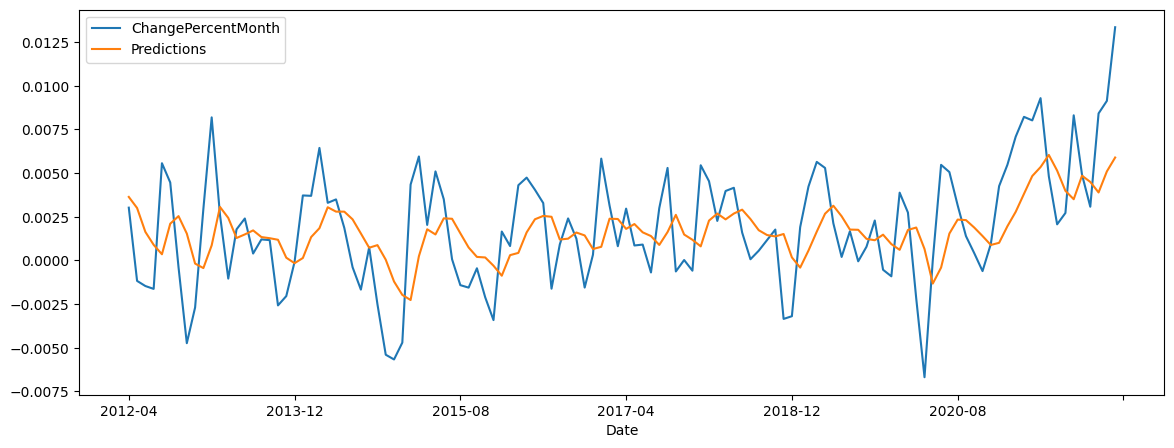

In [14]:
cpi_test.set_index('Date', inplace = True)
cpi_test.plot(figsize=(14,5))
uni_rmse=sqrt(mean_squared_error(cpi_test['ChangePercentMonth'],cpi_test['Predictions']))
print('Test RMSE:' , uni_rmse)